In [64]:
import hypergraph
import time
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [65]:
G = hypergraph.HyperGraph()

In [66]:
dataset = "trivago-clicks"

In [67]:
with open("dataset/{}/hyperedges-{}.txt".format(dataset, dataset)) as f:
  for line in f:
    hyperedge = list(map(int, line.rstrip("\n").split(",")))
    G.E.append(hyperedge)

In [68]:
labels = []
with open("dataset/{}/node-labels-{}.txt".format(dataset, dataset)) as f:
  for line in f:
    labels.append(int(line[0]))

In [69]:
v_max = 0
for edge in G.E:
  for j in edge:
    if v_max <= j:
      v_max = j
G.V = [i for i in range(1, v_max+1)]

In [70]:
G.elist = {v: [] for v in G.V}
for i in range(len(G.E)):
  for v in G.E[i]:
    G.elist[v].append(i)

In [71]:
#ノードiの隣接ノード取得
def get_adj(E, elist, node):
  adj = []
  for i in elist[node]:
    for j in E[i]:
      if j != node:
        adj.append(j)
  return adj

In [72]:
for node in G.V:
  G.adj.append(get_adj(G.E, G.elist, node))

In [73]:
def get_K(V, E, beta=1):
  K = [[0 for i in range(len(V))] for j in range(len(V))]
  count = 0
  percentage = 0
  for edge in E:
    for i in range(len(edge)):
      for j in range(i+1, len(edge)):
        K[edge[i]-1][edge[j]-1] += (len(edge)-1) ** beta
        K[edge[j]-1][edge[i]-1] += (len(edge)-1) ** beta
    count += 1
    if percentage <= (count/len(E))*100:
      print("about", (count/len(E))*100, "percent done.")
      percentage += 1
  return np.array(K)


def trans_prob(V, K):
  K_row = np.array([np.sum(K[i]) for i in range(len(V))])
  T = np.array([[K[i][j] / K_row[i] for j in range(len(V))] for i in range(len(V))])
  return T

In [74]:
def transition(now_node, T):
  next_node = random.choices([i+1 for i in range(len(T[0]))], k=1, weights=T[now_node-1])
  return next_node[0]

def random_walk(initial_node, walk_length, T):
  now_node = initial_node
  walk = [now_node]
  for step in range(walk_length):
    now_node = transition(now_node, T)
    walk.append(now_node)
  return walk

In [ ]:
#calucurate T
beta = 1
K = get_K(G.V, G.E, beta=beta)
T = trans_prob(G.V, K)

In [19]:
random.seed(0)
walks = [list(map(str, random_walk(i, 30, T))) for i in range(1, len(G.V)+1) for j in range(64)]
model = Word2Vec(walks, sg=1, vector_size=128, window=10, min_count=0)

In [20]:
#ロジスティック回帰
X = [model.wv[str(node)] for node in G.V]
Y = np.array(labels)  

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True) 

lr = LogisticRegression() 
lr.fit(X_train, Y_train) # ロジスティック回帰モデルの重みを学習

Y_pred = lr.predict(X_test)

In [21]:
print('confusion matrix = \n', confusion_matrix(y_true=Y_test, y_pred=Y_pred))
print('accuracy = ', accuracy_score(y_true=Y_test, y_pred=Y_pred))
print('precision = ', precision_score(y_true=Y_test, y_pred=Y_pred, average="micro"))
print('recall = ', recall_score(y_true=Y_test, y_pred=Y_pred, average="micro"))
print('f1 score = ', f1_score(y_true=Y_test, y_pred=Y_pred, average="micro"))

confusion matrix = 
 [[26  2]
 [ 6 25]]
accuracy =  0.864406779661017
precision =  0.864406779661017
recall =  0.864406779661017
f1 score =  0.864406779661017


In [24]:
#図作る
def create_model(G, T, walk_length, walk_num, emb_dim, window_size=10):
  walks = [list(map(str, random_walk(i, walk_length, T))) for i in range(1, len(G.V)+1) for j in range(walk_num)]
  model = Word2Vec(walks, sg=1, vector_size=emb_dim, window=window_size, min_count=0)
  return model

def F1_score(G, model, test_size=0.2):
  X = [model.wv[str(node)] for node in G.V]
  Y = np.array(labels)  

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=0, shuffle=True) 

  lr = LogisticRegression() 
  lr.fit(X_train, Y_train) # ロジスティック回帰モデルの重みを学習

  Y_pred = lr.predict(X_test)

  micro_f1 = f1_score(y_true=Y_test, y_pred=Y_pred, average="micro")
  macro_f1 = f1_score(y_true=Y_test, y_pred=Y_pred, average="macro")

  return micro_f1, macro_f1

In [ ]:
#これ意味ない

fig, axes = plt.subplots(1, 2)

for walk_num in range(5, 70):
  model = create_model(G, T, walk_length=20, walk_num=walk_num, emb_dim=8, window_size=10)
  micro, macro = F1_score(G, model)
  axes[0].scatter(walk_num, micro, color="blue")
  axes[1].scatter(walk_num, macro, color="blue")
  print("finish ", walk_num)
axes[0].set_xlabel("walk_num")
axes[0].set_ylabel("micro-F1")
axes[1].set_xlabel("walk_num")
axes[1].set_ylabel("macro-F1")
plt.show()

In [61]:
#実験実行、実験結果ファイル出力
print(datetime.datetime.now())
betas = [-1, 0, 1]
for beta in betas:
  print("start beta={}".format(beta))
  K = get_K(G.V, G.E, beta=beta)
  T = trans_prob(G.V, K)
  print("finish calcurating T")
  print(datetime.datetime.now())

  walk_length = 20
  walk_nums = [8, 16, 32, 64]
  ed = 64

  dir_path = "result_data/{}/gamma-f1".format(dataset)

  for walk_num in walk_nums:
      f = open('{}/beta{}-d{}-gamma{}-length{}.txt'.format(dir_path, beta, ed, walk_num, walk_length), 'w')
      f.writelines(["beta=", str(beta), " ", "d=", str(ed), " ", "gamma=", str(walk_num), " ", "walk_length=", str(walk_length), "\n"])

      for i in range(20):
        random.seed(i)
        model = create_model(G, T, walk_length=walk_length, walk_num=walk_num, emb_dim=ed, window_size=10)
        micro, macro = F1_score(G, model)
        datalist = [str(micro), " ", str(macro), "\n"]
        f.writelines(datalist)
        print("finish ", i)
      f.close()
      print("walk_num={}:finish".format(walk_num))
      print(datetime.datetime.now())

start beta=-1
about 0.012790995139421849 percent done.
about 1.0104886160143258 percent done.
about 2.0081862368892303 percent done.
about 3.0058838577641342 percent done.
about 4.003581478639038 percent done.
about 5.001279099513942 percent done.
about 6.0117677155282685 percent done.
about 7.0094653364031725 percent done.
about 8.007162957278076 percent done.
about 9.00486057815298 percent done.
about 10.002558199027884 percent done.
about 11.000255819902788 percent done.
about 12.010744435917115 percent done.
about 13.008442056792019 percent done.
about 14.006139677666923 percent done.
about 15.003837298541828 percent done.
about 16.00153491941673 percent done.
about 17.012023535431055 percent done.
about 18.00972115630596 percent done.
about 19.007418777180867 percent done.
about 20.00511639805577 percent done.
about 21.002814018930675 percent done.
about 22.000511639805577 percent done.
about 23.0110002558199 percent done.
about 24.008697876694807 percent done.
about 25.0063954975

In [62]:
def read_file(beta, d, gamma, length):
  micros = []
  macros = []
  with open("{}/beta{}-d{}-gamma{}-length{}.txt".format(dir_path, beta, d, gamma, length)) as f:
    for line in f:
      if line[0] == "b":
        continue
      else:
        micro, macro = list(map(float, line.rstrip("\n").split(" ")))
        micros.append(micro)
        macros.append(macro)
  micros = np.array(micros)
  std = np.std(micros)

  return np.mean(micros), std

/tmp/ipykernel_20855/1373296568.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-r" (-> color='r'). The keyword argument will take precedence.
  ax.errorbar(X[count], Y_1, yerr=Y_1_err, capsize=5, fmt='o-{}'.format(colors[count]), markersize=10, ecolor='black', markeredgecolor = "black", color='black', label="beta={}".format(beta))
/tmp/ipykernel_20855/1373296568.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-b" (-> color='b'). The keyword argument will take precedence.
  ax.errorbar(X[count], Y_1, yerr=Y_1_err, capsize=5, fmt='o-{}'.format(colors[count]), markersize=10, ecolor='black', markeredgecolor = "black", color='black', label="beta={}".format(beta))
/tmp/ipykernel_20855/1373296568.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o-g" (-> color='g'). The keyword argument will take precedence.
  ax.errorbar(X[count], Y_1

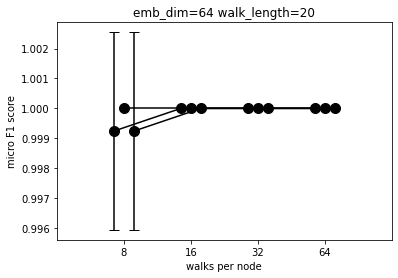

In [63]:
fig, ax = plt.subplots()

betas = [-1, 0, 1]
dims = [8, 16, 32, 64, 128]
nums = [8, 16, 32, 64]
colors = ["r", "b", "g"]
x = [10, 20, 30, 40]
X = [[8.5+j*1.5 + 10*i for i in range(4)] for j in range(len(betas))]
count = 0
for beta in betas:
  Y_1 = []
  Y_1_err = [[], []]
  for num in nums:
    avg, std = read_file(beta, 64, num, 20)
    Y_1.append(avg)
    Y_1_err[0].append(std)
    Y_1_err[1].append(std)

  ax.errorbar(X[count], Y_1, yerr=Y_1_err, capsize=5, fmt='o-{}'.format(colors[count]), markersize=10, ecolor='black', markeredgecolor = "black", color='black', label="beta={}".format(beta))
  count += 1

ax.set_title("emb_dim=64 walk_length=20")
ax.set_xlabel("walks per node")
ax.set_ylabel("micro F1 score")
ax.set_xlim([0, 50])
plt.xticks(x, [8, 16, 32, 64])
#ax.legend(fontsize=8)
plt.show()